In [1]:
import geopandas as gpd
import pandas as pd

## Data Preprocessing
#### We have done some data preprocessing here. We first downloaded slovakia boundary shapefile and did spatial join to get intersected slovakia grid for 2006 and 2021 census

In [2]:
proj_crs = 'EPSG:3035'

### Reading 2021 census

In [3]:
euro_census_within_slovakia_2021 = gpd.read_file('slovakia_census/slovakia_census_2021/slovakia_census_2021.shp')

### Reading 2006 census

In [4]:
euro_census_within_slovakia_2006 = gpd.read_file('slovakia_census/slovakia_census_2006/slovakia_census_2006.shp')

### Rasterizing vector data
#### We have used make_geocube library to rasterize the grid data. Geocube will return xarray object which we can use to perform raster operation on xarray matrix which is similar to numpy array

In [5]:
from geocube.api.core import make_geocube
import xarray as xr
import numpy as np
from shapely.geometry import Point


#### Rasterizing euro_census_within_slovakia_2006 grid data with 1000x1000 meter pixel resolution 
#### Here pops is column in grid geodataframe which hold the census information

In [6]:
# Using GeoCube to rasterize the Vector
census_raster_2006 = make_geocube(
    vector_data=euro_census_within_slovakia_2006,
    measurements=["pops"],
    resolution=(1000, -1000),
    # fill = -999
)

In [7]:
census_raster_2006

<xarray.Dataset>
Dimensions:      (y: 224, x: 406)
Coordinates:
  * y            (y) float64 2.768e+06 2.768e+06 2.77e+06 ... 2.99e+06 2.99e+06
  * x            (x) float64 5.232e+06 5.23e+06 5.23e+06 ... 4.828e+06 4.826e+06
    spatial_ref  int64 0
Data variables:
    pops         (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

#### Rasterizing euro_census_within_slovakia_2021 grid data with 1000x1000 meter pixel resolution 
#### Here pops is column in grid geodataframe which hold the census information

In [8]:
census_raster_2021 = make_geocube(
    vector_data=euro_census_within_slovakia_2021,
    measurements=["pops"],
    resolution=(1000, -1000),
    # fill = -999
)

In [9]:
census_raster_2021

<xarray.Dataset>
Dimensions:      (y: 225, x: 406)
Coordinates:
  * y            (y) float64 2.766e+06 2.768e+06 2.768e+06 ... 2.99e+06 2.99e+06
  * x            (x) float64 5.232e+06 5.23e+06 5.23e+06 ... 4.828e+06 4.826e+06
    spatial_ref  int64 0
Data variables:
    pops         (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan

#### Aligning both rasters as they have different dimension

In [10]:
# Align the two rasters along their dimensions
census_raster_2006, census_raster_2021 = xr.align(census_raster_2006, census_raster_2021, join='outer')

#### Substracting census_raster_2006 from census_raster_2021 to get relative change

In [42]:
result = np.abs(census_raster_2021 - census_raster_2006)
result = result.fillna(0)

#### Getting top 5 highest census relative change values

In [12]:
sorted(result.pops.to_numpy().flatten(), reverse=True)[:5]

[8249.0, 8237.0, 7803.0, 6741.0, 6666.0]

#### Filtering the result with top highest census relative change 

In [13]:
result = result.where(result.pops >= 6666.0)
result = result.fillna(0)

#### Converting pixels of 5 highest relative change to centroid coordinates with their respective census values

In [14]:
pops_change = result.pops.to_numpy()
x,y = np.meshgrid(result.x, result.y)

relative_pops = []
pops_2006 = []
pops_2021 = []
centroids = []

for i in range(pops_change.shape[0]):
    for j in range(pops_change.shape[1]):
        if (pops_change[i][j] > 0):
            relative_pops.append(pops_change[i][j])
            centroids.append(Point(x[i][j], y[i][j]))
            pops_2006.append(census_raster_2006.pops.to_numpy()[i][j])
            pops_2021.append(census_raster_2021.pops.to_numpy()[i][j])

#### Creating dataframe from for centroids and their relative census values

In [15]:
# Create a DataFrame with centroids and pixel values of relative difference
top_5_cells = pd.DataFrame({
    'geometry': centroids,
    'relative_pops_difference': relative_pops,
    'pops_2006': pops_2006,
    'pops_2021': pops_2021
})

top_5_cells = top_5_cells.sort_values(by='relative_pops_difference', ascending=False)

In [16]:
top_5_cells

,geometry,relative_pops_difference,pops_2006,pops_2021
2,POINT (4956500 2936500),8249.0,5006.0,13255.0
0,POINT (4917500 2831500),8237.0,4131.0,12368.0
1,POINT (4993500 2891500),7803.0,4045.0,11848.0
3,POINT (4958500 2937500),6741.0,4271.0,11012.0
4,POINT (5142500 2938500),6666.0,5052.0,11718.0


#### Converting to 4326 projection

In [17]:
top_5_cells = top_5_cells.set_geometry(col='geometry')
top_5_cells = top_5_cells.set_crs(proj_crs)
top_5_cells = top_5_cells.to_crs('EPSG:4326')

#### Saving result to CSV

In [18]:
top_5_cells.to_csv('top_5_cells.csv', index=False)

#### average and median population per 1 square km grid in Slovakia in 2021? 

In [19]:
euro_census_within_slovakia_2021['pops'].mean()

308.17690624473994

In [20]:
euro_census_within_slovakia_2021['pops'].median()

68.0

In [29]:
census_raster_2021.rio.to_raster('census_rasters/census_raster_2021.tiff')
census_raster_2006.rio.to_raster('census_rasters/census_raster_2006.tiff')
result.rio.to_raster('census_rasters/relative_census_difference.tiff')

In [35]:
import matplotlib.pyplot as plt

<xarray.Dataset>
Dimensions:      (y: 225, x: 406)
Coordinates:
  * y            (y) float64 2.766e+06 2.768e+06 2.768e+06 ... 2.99e+06 2.99e+06
  * x            (x) float64 5.232e+06 5.23e+06 5.23e+06 ... 4.828e+06 4.826e+06
    spatial_ref  int64 0
Data variables:
    pops         (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

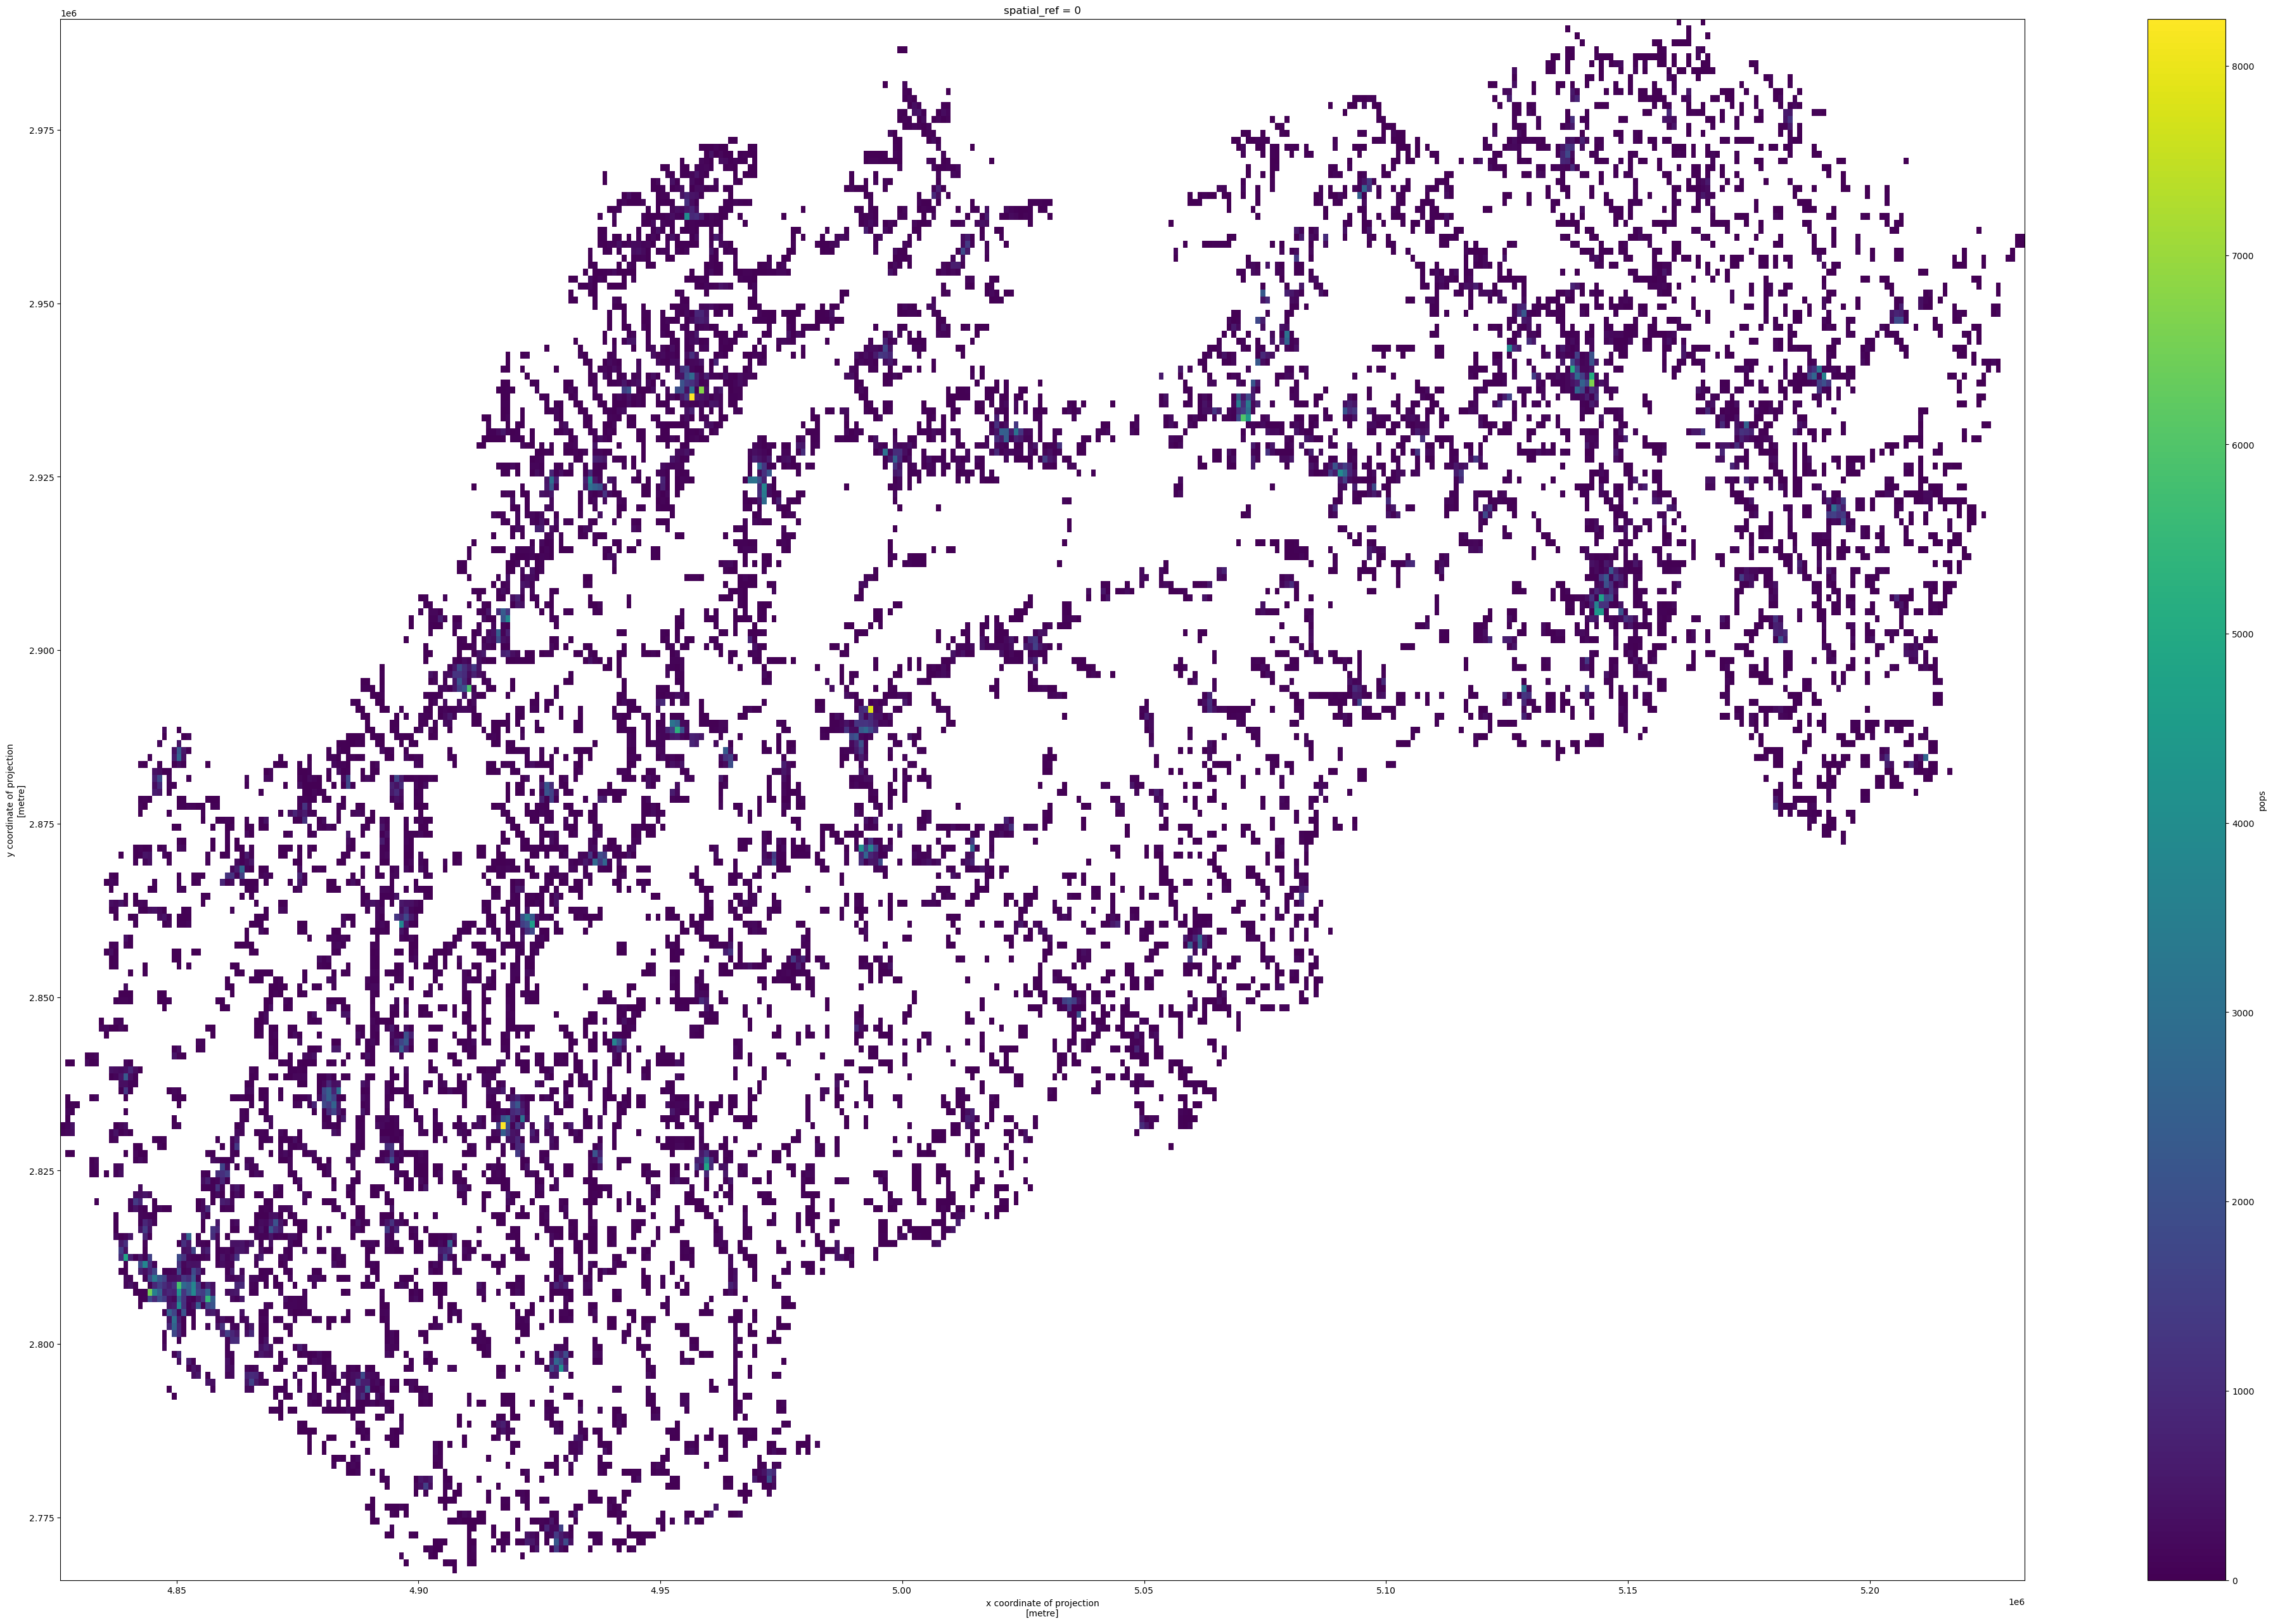

In [53]:
plt.figure(figsize=(50, 32))
result.pops.plot(cmap='viridis')